<a href="https://colab.research.google.com/github/ArthAgrawal/Vision-Transformer-in-SER/blob/main/SER_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
print(os.listdir('/content/drive/MyDrive/RAVDESS/'))


['.DS_Store', 'Actor_09', 'Actor_01', 'Actor_24', 'Actor_06', 'Actor_14', 'Actor_13', 'Actor_08', 'Actor_23', 'Actor_07', 'Actor_22', 'Actor_17', 'Actor_03', 'Actor_02', 'Actor_19', 'Actor_04', 'Actor_05', 'Actor_15', 'Actor_12', 'Actor_10', 'Actor_18', 'Actor_21', 'Actor_11', 'Actor_16', 'Actor_20']


In [ ]:
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Import tqdm

# Path to your dataset
dataset_path = '/content/drive/MyDrive/RAVDESS/'

# Map the numeric emotion codes to labels
label_dict = {
    "01": 0,  # Neutral
    "02": 1,  # Calm
    "03": 2,  # Happy
    "04": 3,  # Sad
    "05": 4,  # Angry
    "06": 5,  # Fearful
    "07": 6,  # Disgust
    "08": 7   # Surprised
}

# Function to load and convert audio to Mel-spectrogram
def audio_to_mel_spectrogram(file_path, sr=22050, n_mels=128, fmin=20, fmax=8000):
    try:
        audio, sr = librosa.load(file_path, sr=sr)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        # Expand dimensions to make it 3D (Height, Width, Channels)
        mel_spectrogram_db = np.expand_dims(mel_spectrogram_db, axis=-1)
        return mel_spectrogram_db
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Function to load RAVDESS dataset and extract Mel-spectrograms and labels
def load_ravdess_data(directory):
    audio_files = []
    labels = []
    print(f"Loading data from {directory}")

    # Iterate through all the actor folders
    for actor_folder in tqdm(os.listdir(directory), desc="Actors", ncols=100):
        if actor_folder == '.DS_Store':  # Ignore .DS_Store
            continue
        actor_folder_path = os.path.join(directory, actor_folder)
        if os.path.isdir(actor_folder_path):
            print(f"Processing folder: {actor_folder_path}")
            for audio_file in tqdm(os.listdir(actor_folder_path), desc=f"Processing files in {actor_folder}", ncols=100):
                if audio_file.endswith(".wav"):
                    emotion_code = audio_file.split("-")[2]
                    emotion = label_dict.get(emotion_code, None)
                    if emotion is not None:
                        audio_path = os.path.join(actor_folder_path, audio_file)
                        mel_spec = audio_to_mel_spectrogram(audio_path)
                        if mel_spec is not None:
                            mel_spec_resized = tf.image.resize(mel_spec, (224, 224))  # Resize to 224x224
                            audio_files.append(mel_spec_resized.numpy())
                            labels.append(emotion)
                    else:
                        print(f"Warning: No label found for emotion code {emotion_code} in file {audio_file}")

    print(f"Loaded {len(audio_files)} files.")
    return np.array(audio_files), np.array(labels)

# Load the data from the dataset
X, y = load_ravdess_data(dataset_path)

# Verify data shapes
if X.size > 0 and y.size > 0:
    print(f"Data loaded successfully. Shape of X: {X.shape}, Shape of y: {y.shape}")
else:
    print("No data loaded. Please check the dataset path and files.")

# Split the data into training and validation sets
if X.size > 0 and y.size > 0:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize the input data
    X_train = X_train / 255.0
    X_val = X_val / 255.0

    print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")


Loading data from /content/drive/MyDrive/RAVDESS/
Processing folder: /content/drive/MyDrive/RAVDESS/Actor_09
Processing file: 03-01-04-01-01-02-09.wav
Processing file: 03-01-03-01-01-01-09.wav
Processing file: 03-01-02-01-01-02-09.wav
Processing file: 03-01-06-02-02-01-09.wav
Processing file: 03-01-02-02-02-02-09.wav
Processing file: 03-01-04-02-01-01-09.wav
Processing file: 03-01-02-02-02-01-09.wav
Processing file: 03-01-01-01-01-02-09.wav
Processing file: 03-01-06-01-01-02-09.wav
Processing file: 03-01-06-02-01-02-09.wav
Processing file: 03-01-01-01-01-01-09.wav
Processing file: 03-01-04-02-01-02-09.wav
Processing file: 03-01-02-02-01-02-09.wav
Processing file: 03-01-05-01-02-01-09.wav
Processing file: 03-01-02-01-02-01-09.wav
Processing file: 03-01-04-01-02-02-09.wav
Processing file: 03-01-01-01-02-01-09.wav
Processing file: 03-01-04-01-02-01-09.wav
Processing file: 03-01-04-01-01-01-09.wav
Processing file: 03-01-05-01-01-01-09.wav
Processing file: 03-01-05-02-02-02-09.wav
Processin

In [ ]:
# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=8)  # 8 classes in the label_dict
y_val = tf.keras.utils.to_categorical(y_val, num_classes=8)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add, Embedding, Reshape, Layer
from tensorflow.keras.models import Model

# Define the PositionalEmbedding class as a layer
class PositionalEmbedding(Layer):
    def __init__(self, num_patches, d_model):
        super(PositionalEmbedding, self).__init__()
        self.positional_embeddings = Embedding(input_dim=num_patches, output_dim=d_model)

    def call(self, inputs):
        num_patches = inputs.shape[1]
        positional_indices = tf.range(start=0, limit=num_patches, delta=1)
        positional_embeddings = self.positional_embeddings(positional_indices)
        return inputs + positional_embeddings


def create_vit_model(input_shape, num_classes, patch_size=16, num_heads=4, num_layers=8, d_model=128):
    # Input Layer
    inputs = Input(shape=input_shape, name="input_layer_1")

    # Convert input into patches using Conv2D with appropriate patch size
    x = Conv2D(filters=d_model, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)

    # Now reshape the output into tokens (patches)
    x = Reshape((-1, d_model))(x)  # Reshape to (batch_size, num_patches, d_model)

    # Number of patches (length of sequence)
    num_patches = x.shape[1]

    # Add positional embeddings using custom PositionalEmbedding layer
    x = PositionalEmbedding(num_patches=num_patches, d_model=d_model)(x)

    # Transformer Encoder Block with Multi-Head Attention and Residual Connection
    for _ in range(num_layers):
        # Multi-Head Attention
        attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        x = Add()([x, attention])  # Add residual connection
        x = LayerNormalization()(x)

        # Feedforward Layer (MLP)
        ff = Dense(d_model, activation='relu')(x)
        ff = Dense(d_model)(ff)
        x = Add()([x, ff])  # Add residual connection
        x = LayerNormalization()(x)
        x = Dropout(0.1)(x)  # Add dropout for regularization

    # After transformer blocks, we need to flatten the sequence of patches
    x = Flatten()(x)

    # Add a Dense layer for final prediction (MLP Head)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs, name="VisionTransformer")

    return model

# Example usage
input_shape = (256, 256, 3)  # Adjust based on your input image size
num_classes = 10  # Number of classes for classification
model = create_vit_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()



Model: "VisionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 128)    │         98,432 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 256, 128)       │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding      │ (None, 256, 128)       │         32,768 │ reshape[0][0]          │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 256, 128)       │        263,808 │ positional_embedding[… │
│ (MultiHeadAttention)      │                        │                │ positional_embedding[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 128)       │              0 │ positional_embedding[… │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 256, 128)       │            256 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256, 128)       │         16,512 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256, 128)       │         16,512 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256, 128)       │              0 │ layer_normalization[0… │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 256, 128)       │            256 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256, 128)       │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 256, 128)       │        263,808 │ dropout_1[0][0],       │
│ (MultiHeadAttention)      │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 256, 128)       │              0 │ dropout_1[0][0],       │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 256, 128)       │            256 │ add_2[0][0]            │
│ (LayerNormalization) 

 Total params: 19,354,634 (73.83 MB)

 Trainable params: 19,354,634 (73.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Import tqdm for progress bars
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add, Embedding, Reshape, Layer
from tensorflow.keras.models import Model

# Path to your dataset
dataset_path = '/content/drive/MyDrive/RAVDESS/'

# Map the numeric emotion codes to labels
label_dict = {
    "01": 0,  # Neutral
    "02": 1,  # Calm
    "03": 2,  # Happy
    "04": 3,  # Sad
    "05": 4,  # Angry
    "06": 5,  # Fearful
    "07": 6,  # Disgust
    "08": 7   # Surprised
}

# Function to load and convert audio to Mel-spectrogram
def audio_to_mel_spectrogram(file_path, sr=22050, n_mels=128, fmin=20, fmax=8000):
    try:
        audio, sr = librosa.load(file_path, sr=sr)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        # Expand dimensions to make it 3D (Height, Width, Channels)
        mel_spectrogram_db = np.expand_dims(mel_spectrogram_db, axis=-1)
        return mel_spectrogram_db
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Function to load RAVDESS dataset and extract Mel-spectrograms and labels
def load_ravdess_data(directory):
    audio_files = []
    labels = []
    print(f"Loading data from {directory}")

    # Iterate through all the actor folders
    for actor_folder in tqdm(os.listdir(directory), desc="Actors", ncols=100):
        if actor_folder == '.DS_Store':  # Ignore .DS_Store
            continue
        actor_folder_path = os.path.join(directory, actor_folder)
        if os.path.isdir(actor_folder_path):
            print(f"Processing folder: {actor_folder_path}")
            for audio_file in tqdm(os.listdir(actor_folder_path), desc=f"Processing files in {actor_folder}", ncols=100):
                if audio_file.endswith(".wav"):
                    emotion_code = audio_file.split("-")[2]
                    emotion = label_dict.get(emotion_code, None)
                    if emotion is not None:
                        audio_path = os.path.join(actor_folder_path, audio_file)
                        mel_spec = audio_to_mel_spectrogram(audio_path)
                        if mel_spec is not None:
                            mel_spec_resized = tf.image.resize(mel_spec, (224, 224))  # Resize to 224x224
                            audio_files.append(mel_spec_resized.numpy())
                            labels.append(emotion)
                    else:
                        print(f"Warning: No label found for emotion code {emotion_code} in file {audio_file}")

    print(f"Loaded {len(audio_files)} files.")
    return np.array(audio_files), np.array(labels)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

class VisionTransformer(models.Model):
    def __init__(self, num_classes, img_size=224, patch_size=16, embed_dim=768, num_heads=12, num_layers=12, mlp_dim=3072, dropout_rate=0.1):
        super(VisionTransformer, self).__init__()

        self.num_classes = num_classes
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.mlp_dim = mlp_dim
        self.dropout_rate = dropout_rate

        # Patch Embedding layer
        self.patch_embed = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size, padding='valid')

        # Positional Encoding (learned)
        self.position_embedding = layers.Embedding(input_dim=(img_size // patch_size) ** 2, output_dim=embed_dim)

        # Transformer Encoder layers
        self.transformer_blocks = [self._transformer_block(embed_dim, num_heads, mlp_dim, dropout_rate) for _ in range(num_layers)]

        # MLP Head
        self.classifier = layers.Dense(num_classes, activation='softmax')

    def _transformer_block(self, embed_dim, num_heads, mlp_dim, dropout_rate):
        inputs = layers.Input(shape=(None, embed_dim))

        # Multi-Head Self Attention
        attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
        attention = layers.Dropout(dropout_rate)(attention)
        attention = layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

        # Feed Forward Network
        ff = layers.Dense(mlp_dim, activation='relu')(attention)
        ff = layers.Dropout(dropout_rate)(ff)
        ff = layers.Dense(embed_dim)(ff)
        ff = layers.LayerNormalization(epsilon=1e-6)(attention + ff)

        return models.Model(inputs, ff)

    def call(self, inputs):
        # Patch Embedding
        x = self.patch_embed(inputs)  # Shape: (batch_size, num_patches, embed_dim)
        x = layers.Reshape((-1, self.embed_dim))(x)  # Flatten patches

        # Add positional encoding
        positions = tf.range(start=0, limit=(self.img_size // self.patch_size) ** 2, delta=1)
        positions = self.position_embedding(positions)
        x += positions  # Add positional embeddings to patch embeddings

        # Apply Transformer blocks
        for transformer in self.transformer_blocks:
            x = transformer(x)

        # Classifier head (take the [CLS] token representation)
        x = layers.GlobalAveragePooling1D()(x)
        x = self.classifier(x)

        return x

# Example usage
input_shape = (224, 224, 3)  # Image size (224x224)
num_classes = 10  # Number of output classes

model = VisionTransformer(num_classes=num_classes)
model.build((None, *input_shape))
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'vision_transformer', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "vision_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, None, 768)           │      33,065,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, None, 768)           │      33,065,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_2 (Functional)            │ (None, None, 768)           │      33,065,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_3 (Functional)            │ (None, None, 768)           │      33,065,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_4 (Functional)            │ (None, None, 768)           │      33,065,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_5 (Functional)            │ (None, None, 768)           │      33,065,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_6 (Functional)            │ (None, None, 768)           │      33,065,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_7 (Functional)            │ (None, None, 768)           │      33,065,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_8 (Functional)            │ (None, None, 768)           │      33,065,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_9 (Functional)            │ (None, None, 768)           │      33,065,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_10 (Functional)           │ (None, None, 768)           │      33,065,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_11 (Functional)           │ (None, None, 768)           │      33,065,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 396,785,664 (1.48 GB)

 Trainable params: 396,785,664 (1.48 GB)

 Non-trainable params: 0 (0.00 B)

Loading data from /content/drive/MyDrive/RAVDESS/


Actors:   0%|                                                                | 0/25 [00:00<?, ?it/s]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_09



Actors:   8%|████▍                                                   | 2/25 [00:01<00:16,  1.41it/s]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_01



Actors:  12%|██████▋                                                 | 3/25 [00:02<00:23,  1.07s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_24



Actors:  16%|████████▉                                               | 4/25 [00:04<00:24,  1.16s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_06



Actors:  20%|███████████▏                                            | 5/25 [00:05<00:24,  1.21s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_14



Actors:  24%|█████████████▍                                          | 6/25 [00:06<00:23,  1.23s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_13



Actors:  28%|███████████████▋                                        | 7/25 [00:08<00:22,  1.23s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_08



Actors:  32%|█████████████████▉                                      | 8/25 [00:09<00:20,  1.23s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_23



Actors:  36%|████████████████████▏                                   | 9/25 [00:10<00:19,  1.24s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_07



Actors:  40%|██████████████████████                                 | 10/25 [00:11<00:18,  1.24s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_22



Actors:  44%|████████████████████████▏                              | 11/25 [00:13<00:17,  1.26s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_17



Actors:  48%|██████████████████████████▍                            | 12/25 [00:14<00:18,  1.43s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_03



Actors:  52%|████████████████████████████▌                          | 13/25 [00:16<00:18,  1.55s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_02



Actors:  56%|██████████████████████████████▊                        | 14/25 [00:18<00:17,  1.55s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_19



Actors:  60%|█████████████████████████████████                      | 15/25 [00:19<00:14,  1.48s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_04



Actors:  64%|███████████████████████████████████▏                   | 16/25 [00:20<00:12,  1.43s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_05



Actors:  68%|█████████████████████████████████████▍                 | 17/25 [00:22<00:11,  1.39s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_15



Actors:  72%|███████████████████████████████████████▌               | 18/25 [00:23<00:09,  1.36s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_12



Actors:  76%|█████████████████████████████████████████▊             | 19/25 [00:24<00:08,  1.35s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_10



Actors:  80%|████████████████████████████████████████████           | 20/25 [00:26<00:06,  1.33s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_18



Actors:  84%|██████████████████████████████████████████████▏        | 21/25 [00:27<00:05,  1.31s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_21



Actors:  88%|████████████████████████████████████████████████▍      | 22/25 [00:28<00:03,  1.33s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_11



Actors:  92%|██████████████████████████████████████████████████▌    | 23/25 [00:30<00:02,  1.37s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_16



Actors:  96%|████████████████████████████████████████████████████▊  | 24/25 [00:31<00:01,  1.43s/it]

Processing folder: /content/drive/MyDrive/RAVDESS/Actor_20



Actors: 100%|███████████████████████████████████████████████████████| 25/25 [00:33<00:00,  1.33s/it]


Loaded 1440 files.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'vision_transformer_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 55s 435ms/step - accuracy: 0.1258 - loss: 4.7850 - val_accuracy: 0.1354 - val_loss: 2.1308 - learning_rate: 1.0000e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - accuracy: 0.1431 - loss: 2.1572 - val_accuracy: 0.1319 - val_loss: 2.2675 - learning_rate: 1.2589e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - accuracy: 0.1303 - loss: 2.2049 - val_accuracy: 0.1215 - val_loss: 2.1969 - learning_rate: 1.5849e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - accuracy: 0.1191 - loss: 2.2176 - val_accuracy: 0.1319 - val_loss: 2.1720 - learning_rate: 1.9953e-04


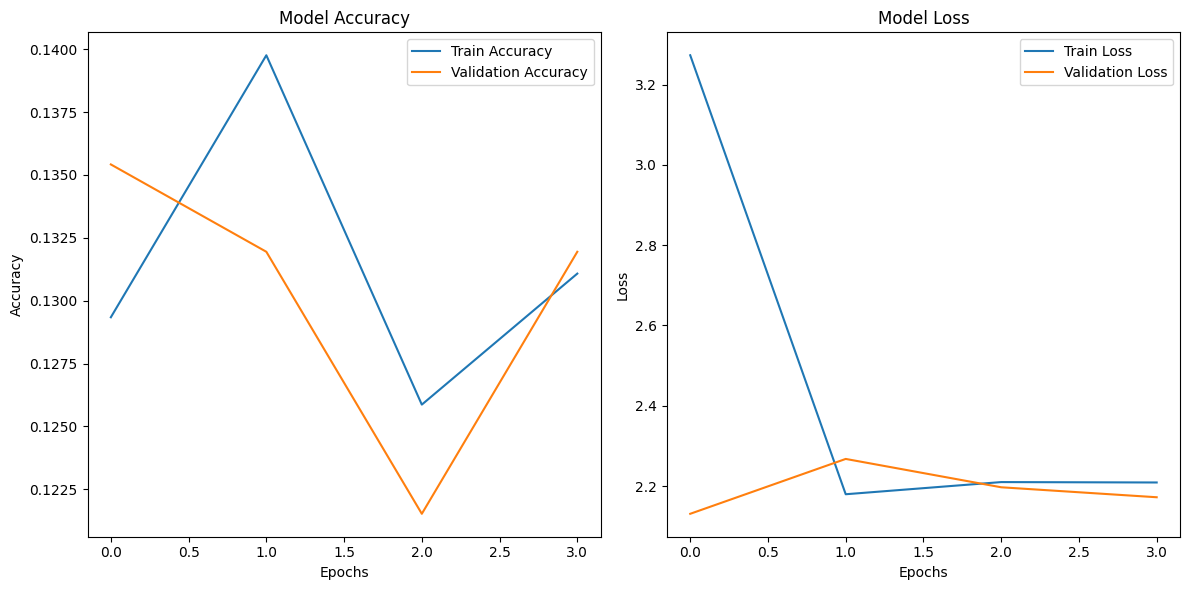

In [ ]:
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add, Embedding, Reshape, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler

# Path to your dataset
dataset_path = '/content/drive/MyDrive/RAVDESS/'

# Map the numeric emotion codes to labels
label_dict = {
    "01": 0,  # Neutral
    "02": 1,  # Calm
    "03": 2,  # Happy
    "04": 3,  # Sad
    "05": 4,  # Angry
    "06": 5,  # Fearful
    "07": 6,  # Disgust
    "08": 7   # Surprised
}

# Function to load and convert audio to Mel-spectrogram
def audio_to_mel_spectrogram(file_path, sr=22050, n_mels=128, fmin=20, fmax=8000):
    try:
        audio, sr = librosa.load(file_path, sr=sr)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mel_spectrogram_db = np.expand_dims(mel_spectrogram_db, axis=-1)
        return mel_spectrogram_db
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Function to load RAVDESS dataset and extract Mel-spectrograms and labels
def load_ravdess_data(directory):
    audio_files = []
    labels = []
    print(f"Loading data from {directory}")

    # Iterate through all the actor folders
    for actor_folder in tqdm(os.listdir(directory), desc="Actors", ncols=100):
        if actor_folder == '.DS_Store':  # Ignore .DS_Store
            continue
        actor_folder_path = os.path.join(directory, actor_folder)
        if os.path.isdir(actor_folder_path):
            print(f"Processing folder: {actor_folder_path}")
            for audio_file in tqdm(os.listdir(actor_folder_path), desc=f"Processing files in {actor_folder}", ncols=100):
                if audio_file.endswith(".wav"):
                    emotion_code = audio_file.split("-")[2]
                    emotion = label_dict.get(emotion_code, None)
                    if emotion is not None:
                        audio_path = os.path.join(actor_folder_path, audio_file)
                        mel_spec = audio_to_mel_spectrogram(audio_path)
                        if mel_spec is not None:
                            mel_spec_resized = tf.image.resize(mel_spec, (224, 224))  # Resize to 224x224
                            audio_files.append(mel_spec_resized.numpy())
                            labels.append(emotion)
                    else:
                        print(f"Warning: No label found for emotion code {emotion_code} in file {audio_file}")

    print(f"Loaded {len(audio_files)} files.")
    return np.array(audio_files), np.array(labels)

# Load the RAVDESS dataset
audio_files, labels = load_ravdess_data(dataset_path)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(audio_files, labels, test_size=0.2, random_state=42)

# Normalize the data to zero mean and unit variance
mean = np.mean(X_train, axis=(0, 1, 2), keepdims=True)
std = np.std(X_train, axis=(0, 1, 2), keepdims=True)
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std

# Create the ViT model (Assuming you already have the ViT model implementation)
model = VisionTransformer(num_classes=8)  # 8 emotions in the RAVDESS dataset
model.build((None, 224, 224, 1))  # Input shape for single-channel (grayscale) images

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',  # Use sparse for integer labels
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch / 10))

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step


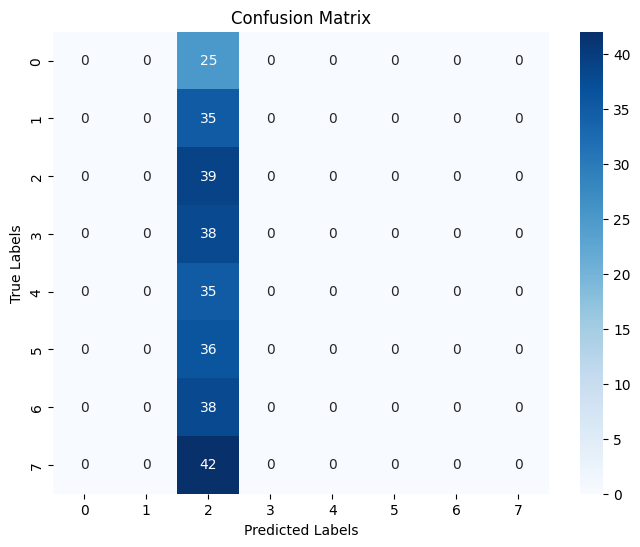

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class with the highest probability

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_dict.values()), yticklabels=list(label_dict.values()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
